<a href="https://colab.research.google.com/github/sharmashubam/pyTorch_basics/blob/main/03_computer_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch 
from torch import nn

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

torch.__version__


'2.0.0+cu118'

In [3]:
# train
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None 
)

# testing data
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

100%|██████████| 26421880/26421880 [00:01<00:00, 16525099.21it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 296793.35it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5568448.88it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 12096513.72it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



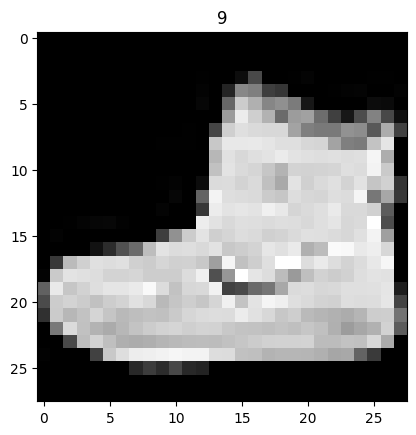

In [5]:
img, label = train_data[0]
img.shape
plt.imshow(img.squeeze() , cmap='gray')
plt.title(label);

In [6]:
from torch.utils.data import DataLoader

BATCH_SIZE= 32
train_dataloader = DataLoader(train_data,
    batch_size=BATCH_SIZE, 
    shuffle=True
) 



test_dataloader = DataLoader(test_data,
                             batch_size=BATCH_SIZE,
                             shuffle = True)


# print(len(train_dataloader) , len(test_dataloader))

# didnot understand this

train_features_batch, train_labels_batch = next(iter(train_dataloader))
print(train_labels_batch)


tensor([3, 5, 8, 3, 0, 0, 1, 4, 2, 1, 2, 1, 9, 7, 6, 3, 3, 2, 2, 6, 1, 1, 2, 9,
        1, 3, 1, 1, 5, 5, 7, 8])


In [8]:
# baseline model (model_0)

flatten_model = nn.Flatten()



In [7]:
from torch import nn
class FirstModelV0(nn.Module):
  def __init__(self, input_shape: int ,hidden_units: int , output_shape:int ):
    super().__init__()
    self.layer_stack= nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features= input_shape, out_features= hidden_units),
        nn.Linear(in_features= hidden_units, out_features=output_shape)

    )

  def forward(self, x):
    return self.layer_stack(x)


In [9]:
# See classes
class_names = train_data.classes
class_names


['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [10]:

model_0 = FirstModelV0(input_shape=784, # one for every pixel (28x28)
    hidden_units=10,
    output_shape=len(class_names)
)

model_0

FirstModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [11]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  # Note: you need the "raw" GitHub URL for this to work
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

In [12]:
# Import accuracy metric
from helper_functions import accuracy_fn 

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss() 
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)


In [13]:
from timeit import default_timer as timer 
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format). 
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [15]:
def accuracy_fn(y_pred,y_true):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [28]:
torch.manual_seed(42)

epochs= 3

for epoch in range(epochs):
  train_loss=0

  for batch, (X,y) in enumerate(train_dataloader):
    model_0.train()

    # do teh forward pass
    y_pred = model_0(X)

    # calculate the loss
    train_loss += loss_fn(y_pred ,y)

    # optimizer
    optimizer.zero_grad()  

    # step ,step , step
    optimizer.step()
    if batch % 400 == 0:
      print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

    
  train_loss /= len(train_dataloader)

  # testing

  model_0.eval()
  test_loss, test_acc = 0, 0 
  with torch.inference_mode() :
    for X, y in test_dataloader:
      test_pred = model_0(X)

      # calculate the loss
      test_loss += loss_fn(test_pred, y)

      test_acc+= accuracy_fn(y_true=y, y_pred=torch.softmax(test_pred, dim=1).argmax(dim=1)) 

    
    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)

  print(f"\nTrain loss: {train_loss:.2f} | Test loss: {test_loss:.2f}, Test acc: {test_acc:.2f}%\n")



Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 2.31 | Test loss: 2.31, Test acc: 9.76%

Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 2.31 | Test loss: 2.31, Test acc: 9.75%

Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 2.31 | Test loss: 2.31, Test acc: 9.76%



In [29]:
# function to test the model and get the results
torch.manual_seed(42)
def eval_model(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               accuracy_fn):
    
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:

            y_pred = model(X)
            

            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, 
                                y_pred=y_pred.argmax(dim=1)) # For accuracy, need the prediction labels (logits -> pred_prob -> pred_labels)
        

        loss /= len(data_loader)
        acc /= len(data_loader)
        
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

# Calculate model 0 results on test dataset
model_0_results = eval_model(model=model_0, data_loader=test_dataloader,
    loss_fn=loss_fn, accuracy_fn=accuracy_fn
)

model_0_results

{'model_name': 'FirstModelV0',
 'model_loss': 2.3136112689971924,
 'model_acc': 9.754392971246006}

In [30]:
# agnostic device setup
import torch
device = "cuda" if torch.cuda.is_available else "cpu"
device

'cuda'

In [31]:
# crearting model_1 , adding some non-linearity
class SecondModel_2(nn.Module):
  def __init__(self, input_shape:int, hidden_units:int , output_shape: int ):
    super().__init__()
    self.layer_stack=nn.Sequential(
        
        nn.Flatten(),
        nn.Linear(in_features= input_shape, out_features= hidden_units),
        nn.ReLU(),
        nn.Linear(in_features= hidden_units, out_features=output_shape),
        nn.ReLU()

    )

  def forward(self, x):
    return self.layer_stack(x)
